In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

In [4]:
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [14]:
#locate files
directory = r'D:\VP\ARTICLE2\ArticleData'

IGT_data = {s:pd.read_csv(r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s]),header = None) for s in specie}

In [15]:
IGT_data['E'].head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.007600,0.0,0.033721,0.482089,0.364741,0.0,0.019985,0.014192,0.111582,0.019961,0.052168
1,0.003304,0.007415,0.0,0.028350,0.526287,0.426632,0.0,0.018707,0.025258,0.127588,0.025910,0.056082
2,0.000000,0.007105,0.0,0.023312,0.574601,0.478963,0.0,0.017764,0.030188,0.127443,0.029043,0.061203
3,0.000000,0.006848,0.0,0.020177,0.621447,0.529072,0.0,0.016792,0.028381,0.129338,0.028291,0.064987
4,0.000000,0.007013,0.0,0.017711,0.627650,0.567414,0.0,0.015747,0.025710,0.133578,0.028286,0.069752


In [17]:
cols = ['{}{}'.format(s,x) for s in ['Copper','Methomyl','Zinc'] for x in range(4)]
for s in specie:
    IGT_data[s].columns = cols

# FDA

Smoothing has already been applied here, what is need is bspline with knots

In [18]:
import skfda
from skfda.misc.hat_matrix import (
    NadarayaWatsonHatMatrix,
)
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.representation.grid import FDataGrid

## Gammarus example

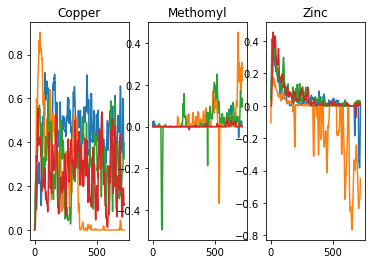

In [35]:
df = IGT_data['G'].copy()
fig,axe = plt.subplots(1,3)
for i,s in enumerate(['Copper','Methomyl','Zinc']):
    for x in range(4):
        axe[i].plot(df.index,df['{}{}'.format(s,x)])
    axe[i].set_title(s)

## Knots and BSpline parameters

Make df divisible by 30

automatic addition of boundary knots so only add one

number of basis functions?

In [36]:
timestep = 30
full_length = df.shape[0]
df = df.iloc[:(full_length//timestep)*timestep]
df.shape

(720, 12)

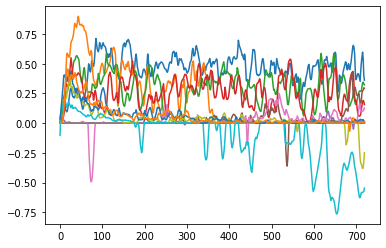

In [37]:
grid_points = np.arange(df.shape[0])
data_matrix = np.transpose(np.array(df))

fd = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
)

fd.plot()
plt.show()

In [30]:
from skfda.representation.basis import (
    BSplineBasis,
)

In [51]:
domain_range = (0,df.shape[0])
order = 4
knots = np.arange(0,df.shape[0]+timestep,timestep)
n_basis = len(knots) + order - 2
knots

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720])

## F Data Basis

This is recreating the BSPline class although it could be done manually in documentation

In [65]:
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

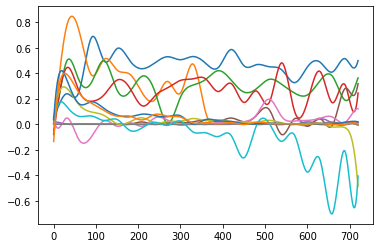

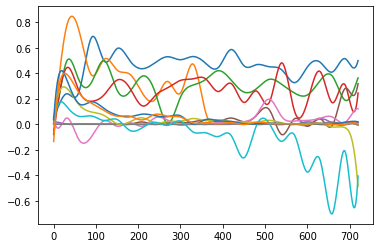

In [53]:
substances = ['Copper','Methomyl','Zinc']
X,y = fd,[substances[i//4] for i in range(12)]
X_basis = X.to_basis(bss)
X_basis.plot()

## FDA using basis functions

In [54]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

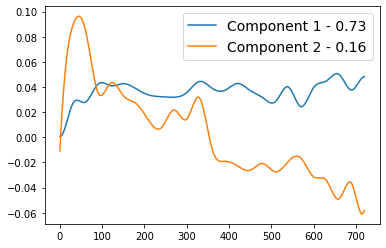

In [55]:
fpca_discretized = FPCA(n_components=2)
fpca_discretized.fit(X_basis)
fpca_discretized.components_.plot()
plt.legend(labels=['Component 1 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[0]),'Component 2 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[1])],fontsize = 14)

### FPCA plots

In [56]:
import seaborn as sns

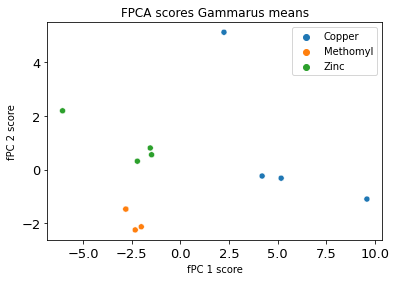

In [58]:
scores = fpca_discretized.fit_transform(X_basis)

fig_meanFPCA,ax_meanFPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_meanFPCA)
ax_meanFPCA.set_xlabel("fPC 1 score")
ax_meanFPCA.set_ylabel("fPC 2 score")
ax_meanFPCA.set_title("FPCA scores Gammarus means")

ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

# Multiple Vector FDA

Show the curves in their multiple vector base form.

In [60]:
timestep = 30
full_length = IGT_data['E'].shape[0]
n_rows = (full_length//timestep)*timestep

domain_range = (0,n_rows)
order = 4
knots = np.arange(0,df.shape[0]+timestep,timestep)
n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720])

In [61]:
substances = ['Copper','Methomyl','Zinc']
y = [substances[i//4] for i in range(12)]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

In [79]:
grid_points = np.arange(n_rows)
data_matrix = np.transpose(np.array([
    np.array(IGT_data['E'].iloc[:n_rows]),
    np.array(IGT_data['G'].iloc[:n_rows]),
    np.array(IGT_data['R'].iloc[:n_rows]),
]))

fd = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
)

In [80]:
from skfda.representation.basis import (
    VectorValuedBasis,
)

In [81]:
bss_all = skfda.representation.basis.VectorValuedBasis([bss for i in range(3)])

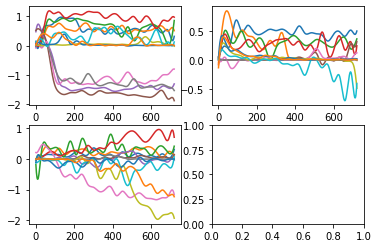

In [82]:
X_basis = fd.to_basis(bss_all)
X_basis.plot()
plt.show()

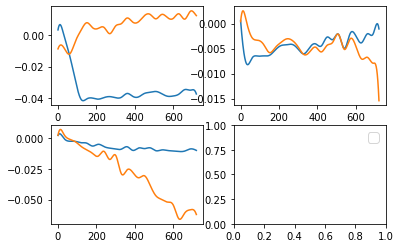

In [83]:
fpca_discretized = FPCA(n_components=2)
fpca_discretized.fit(X_basis)
fpca_discretized.components_.plot()
plt.legend(labels=['Component 1 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[0]),'Component 2 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[1])],fontsize = 14)

## Whilst there IS a vector based way of showinig the data

Currently there is no wa